In [10]:
import pandas
import json 
from sklearn.linear_model import MultiTaskElasticNetCV, ElasticNetCV
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import normalize
from sklearn.ensemble import BaggingRegressor
from scipy.stats import pearsonr
from matplotlib import use; use('Agg')
import matplotlib.pyplot as plt 
%matplotlib inline

In [11]:
!ls benchmarks/*sc
!wc -l benchmarks/*sc 

benchmarks/clean_repack_score.sc benchmarks/original.sc           benchmarks/whole60.sc
benchmarks/detect.sc             benchmarks/whole.sc
benchmarks/nstruct100.sc         benchmarks/whole10.sc
     123 benchmarks/clean_repack_score.sc
     123 benchmarks/detect.sc
   10398 benchmarks/nstruct100.sc
   10398 benchmarks/original.sc
     119 benchmarks/whole.sc
    1220 benchmarks/whole10.sc
    9960 benchmarks/whole60.sc
   32341 total


# Using the structural metrics calculated by the enzyme design mover 

------------------------------------------------------------------------
Scorefile: "benchmarks/original.sc"
------------------------------------------------------------------------
Training on constant "kcat" ... done
Training on constant "1/km" ... done
Training on constant "kcat/km" ... done
------------------------------------------------------------------------
Scorefile: "benchmarks/whole10.sc"
------------------------------------------------------------------------
Training on constant "kcat" ... done
Training on constant "1/km" ... done
Training on constant "kcat/km" ... done
------------------------------------------------------------------------
Scorefile: "benchmarks/whole60.sc"
------------------------------------------------------------------------
Training on constant "kcat" ... done
Training on constant "1/km" ... done
Training on constant "kcat/km" ... done
------------------------------------------------------------------------
Scorefile: "benchmarks/detect.sc"
-------

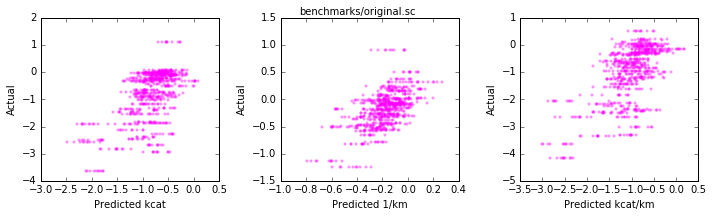

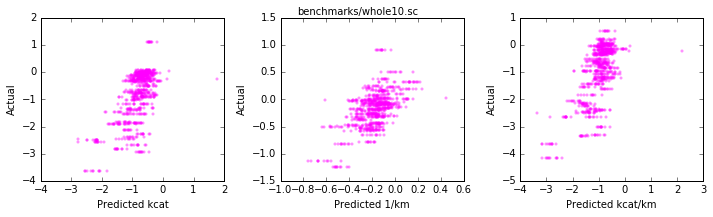

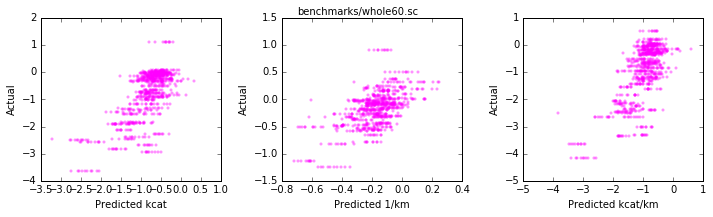

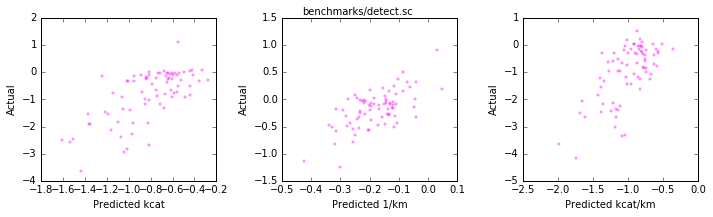

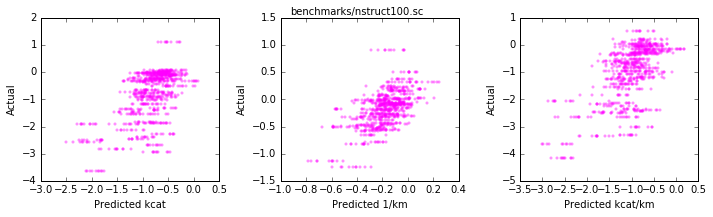

In [12]:
%%timeit -r1 -n1

# this is the new benchmark script 

def low_10( df ):
    return df.sort_values( by='total_score' ).head( 10 )

for scorefile in [ 'benchmarks/original.sc', 'benchmarks/whole10.sc', 'benchmarks/whole60.sc', 
                   'benchmarks/detect.sc', 'benchmarks/nstruct100.sc' ]:
    
    print '------------------------------------------------------------------------'
    print 'Scorefile: "{}"'.format( scorefile )
    print '------------------------------------------------------------------------'
    
    df = pandas.read_csv( scorefile, sep=r'\s+' ).dropna()
    df.description = df.description.str[:-5]
    df = df.groupby( 'description' ).apply( low_10 )
    df.set_index( 'description', inplace=True )

    train_set = pandas.read_csv( '../data/train_set.csv' )
    train_set.set_index( 'mutant', inplace=True )

    fig, ax = plt.subplots( ncols=3, nrows=1, figsize=(10,3) )
    constants = [ 'kcat', '1/km', 'kcat/km' ]
    result = {} 

    for const_index, constant in enumerate( constants ): 

        X = df.join( train_set ).dropna()
        y = X[ constant ].values
        X = X.ix[ :,:'expressed' ].values

        net = ElasticNetCV( normalize=True, selection='random' )

        params_grid = {
            'cv': [ 10 ], 
            'l1_ratio': [ 0.001, 0.01, 0.1, 0.5, 0.9 ], 
        }
        
        print 'Training on constant "{}" ...'.format( constant ) , 
        grid = GridSearchCV( net, params_grid )
        bag = BaggingRegressor( base_estimator=grid, n_estimators=1000, bootstrap_features=True )
        bag.fit( X, y )

        print 'done'
        preds = bag.predict( X )
        pcc = pearsonr( preds, y )
        score = bag.score( X, y )
        
        result.update( { constant: { 'PCC': pcc[0], 'model_score': score, } } )
        ax[ const_index ].scatter( preds, y, alpha=0.3, marker='.', color='magenta' )
        ax[ const_index ].set_xlabel( 'Predicted {}'.format( constant ) )
        ax[ const_index ].set_ylabel( 'Actual' )
        plt.tight_layout()
        
    fig.suptitle( scorefile )
    fig.tight_layout()
    
    # write out results! 
    fig.savefig( '{}'.format( scorefile.replace( '.sc', '.png' ) ) )
    with open( '{}'.format( scorefile.replace( '.sc', '.json' ) ), 'w' ) as fn:
        fn.write( json.dumps( result ) )
